# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-akq7s808
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-akq7s808
     |████████████████████████████████| 71kB 691kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 55.9MB/s 
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368708 sha256=ca50cd1711234696bc9809ccedb0d0bdf899c73c8202c972d692ed9045503387
  Stored in directory: /tmp/pip-ephem-wheel-cache-_qhbmfvw/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=2017d65b9037e4c4a7ddb72fc81f4135f4d7fdc818aa1f35ab388eeccdfa13b6
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built clip ftfy
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  F

# Import Necessary Packages

In [2]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
import torch
from tqdm.notebook import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from torch import nn
from torch.nn.utils.rnn import *
import fnmatch
import clip


cuda = torch.cuda.is_available()
print("cuda", cuda)
num_workers = 8 if cuda else 0
print(num_workers)
print("Torch version:", torch.__version__)
batch_size=8

cuda True
8
Torch version: 1.7.1


## Load CLIP Model

In [3]:
print("Avaliable Models: ", clip.available_models())
model, preprocess = clip.load("RN50") # clip.load("ViT-B/32") #

input_resolution = model.input_resolution #.item()
context_length = model.context_length #.item()
vocab_size = model.vocab_size #.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Avaliable Models:  ['RN50', 'RN101', 'RN50x4', 'ViT-B/32']
Model parameters: 102,007,137
Input resolution: tensor(224, device='cuda:0')
Context length: tensor(77, device='cuda:0')
Vocab size: tensor(49408, device='cuda:0')


## Load Templates


In [9]:
templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

# Selected classes and mapping for kinetics dataset

In [10]:
classnames = ['making tea',
 'shaking head',
 'skiing slalom',
 'bobsledding',
 'high kick',
 'scrambling eggs',
 'bee keeping',
 'swinging on something',
 'washing hands',
 'laying bricks',
 'push up',
 'doing nails',
 'massaging legs',
 'using computer',
 'clapping',
 'drinking beer',
 'eating chips',
 'riding mule',
 'petting animal (not cat)',
 'frying vegetables',
 'skiing (not slalom or crosscountry)',
 'snowkiting',
 'massaging person’s head',
 'cutting nails',
 'picking fruit']

map_id = {}
i=0
for label in classnames:
  map_id[label]=i
  i+=1

In [11]:
map_id

{'bee keeping': 6,
 'bobsledding': 3,
 'clapping': 14,
 'cutting nails': 23,
 'doing nails': 11,
 'drinking beer': 15,
 'eating chips': 16,
 'frying vegetables': 19,
 'high kick': 4,
 'laying bricks': 9,
 'making tea': 0,
 'massaging legs': 12,
 'massaging person’s head': 22,
 'petting animal (not cat)': 18,
 'picking fruit': 24,
 'push up': 10,
 'riding mule': 17,
 'scrambling eggs': 5,
 'shaking head': 1,
 'skiing (not slalom or crosscountry)': 20,
 'skiing slalom': 2,
 'snowkiting': 21,
 'swinging on something': 7,
 'using computer': 13,
 'washing hands': 8}

## Calculate Zeroshot_classifier

In [12]:
classnames_str = {x:x.replace('_', ' ') for x in classnames}
classnames_str

{'bee keeping': 'bee keeping',
 'bobsledding': 'bobsledding',
 'clapping': 'clapping',
 'cutting nails': 'cutting nails',
 'doing nails': 'doing nails',
 'drinking beer': 'drinking beer',
 'eating chips': 'eating chips',
 'frying vegetables': 'frying vegetables',
 'high kick': 'high kick',
 'laying bricks': 'laying bricks',
 'making tea': 'making tea',
 'massaging legs': 'massaging legs',
 'massaging person’s head': 'massaging person’s head',
 'petting animal (not cat)': 'petting animal (not cat)',
 'picking fruit': 'picking fruit',
 'push up': 'push up',
 'riding mule': 'riding mule',
 'scrambling eggs': 'scrambling eggs',
 'shaking head': 'shaking head',
 'skiing (not slalom or crosscountry)': 'skiing (not slalom or crosscountry)',
 'skiing slalom': 'skiing slalom',
 'snowkiting': 'snowkiting',
 'swinging on something': 'swinging on something',
 'using computer': 'using computer',
 'washing hands': 'washing hands'}

In [13]:
import pdb
def zeroshot_classifier(classnames, act_descriptions):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in classnames:
      texts = [template.format(classname) for template in templates]
      # pdb.set_trace()
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights

In [14]:
a = nn.Linear(1024,25)
a.weight.shape

torch.Size([25, 1024])

In [15]:
zeroshot_weights = zeroshot_classifier(classnames, classnames_str)
# print(zeroshot_weights.shape)
# zeroshot_weights1 = zeroshot_weights.expand(batch_size, zeroshot_weights.shape[0], zeroshot_weights.shape[1])
# print(zeroshot_weights.shape)
# print(type(zeroshot_weights))

In [12]:
zeroshot_weights.shape

torch.Size([1024, 25])

In [13]:
# zeroshot_weights_ = torch.autograd.Variable(zeroshot_weights1,requires_grad=True)

In [14]:
## Labels
## To clip encode_text
## 25 * 1024


In [15]:
# def zeroshot_classifier(classnames, act_descriptions):
#     with torch.no_grad():
#         zeroshot_weights = []
#         for classname in tqdm(classnames):
#             #print(classname, act_descriptions[classname])
#             des_size = len(act_descriptions[classname])
#             texts =  [ act_descriptions[classname][x : x+100] for x in range(0, des_size, 100)]#format with class
#             texts = [template.format(texts[0]) for template in templates]
#             # print("\n\n".join(texts), "\n###################################\n")
#             texts = clip.tokenize(texts).cuda() #tokenize
#             # print(texts.shape, "\n###################################\n")
#             class_embeddings = model.encode_text(texts) #embed with text encoder
#             class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
#             class_embedding = class_embeddings.mean(dim=0)
            
#             class_embedding /= class_embedding.norm()
#             zeroshot_weights.append(class_embedding)
#         zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
#     return zeroshot_weights


# zeroshot_weights = zeroshot_classifier(classnames, classnames_str)

# DEVELOP LSTM MODEL

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [17]:
import pdb
# LSTM Model
NUM_CLASSES = 25
class Model(nn.Module):
    def __init__(self, input_feature_size, embed_size, out_phoeneme, hidden_size):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_feature_size, embed_size , kernel_size=2),
            nn.ReLU(),
        )
        # No of layers ---> reduce
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=3,bidirectional=True)
        self.output1 = nn.Linear(hidden_size * 2, 1024)
        # self.output2 = nn.Linear(1024,1024)
        self.dummy = nn.Linear(1024,NUM_CLASSES,bias=False)
        self.dummy.weight = torch.nn.Parameter(zeroshot_weights.float().T.clone(), requires_grad=False)

        # self.dummy.requires_grad = True
        # self.output3 = zeroshot_weights_.float().cuda()

    
    def forward(self, X, lengths):
        X_ = torch.transpose(X,2,1)
        X_ = F.pad(input=X_, pad=(0,1,0,0), mode='constant', value=0)
        X = self.layer1(X_)
        X = torch.transpose(X,0,2)
        X = torch.transpose(X,1,2)
        packed_X = pack_padded_sequence(X, lengths.cpu(), enforce_sorted=False)
        packed_out,(h_n,c_n) = self.lstm(packed_X)
        out,_ = pad_packed_sequence(packed_out)
        out = self.output1(out[0,:,:]) # 1024
        # out /= out.norm(dim=-1, keepdim=True) # Normalize the logits. #### SHOULD WE MULTIPLY BY 100
        logits = self.dummy(out)
        return logits
    
def init_weights(m):
  if type(m) == nn.Conv1d or type(m) == nn.Linear:
    torch.nn.init.xavier_normal_(m.weight.data)    

## Dataloader and Dataset

In [18]:
# Dataset class for Train and Dev
class Dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.data = []
        for file in os.listdir(self.path):
          if fnmatch.fnmatch(file, '*.npz'):
            self.data.append(file)

        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = np.load(os.path.join(self.path,self.data[index]),allow_pickle=True)
        sample = torch.from_numpy(data['data']).type(torch.FloatTensor)
        label  = torch.tensor(data['label'])#.type(torch.LongTensor)
        length = torch.tensor(100)
        return sample,label,length

In [ ]:
# 1024 X 25

In [39]:
# Dataloader train
train_dataset = Dataset("/content/drive/MyDrive/NPZ_TRAIN_16824")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)

# Dataloader dev
# dev_dataset = Dataset(dev_data,dev_labels)
# dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate, num_workers=8)

In [40]:
train_dataset.__len__()

12621

## Train and Test Loop

In [57]:
# Set the hyperparameters of the model
numEpochs = 25
num_feats = 1024
learningRate = 1e-3
weightDecay = 5e-6
num_classes = 25
hidden_size = 512
embed_size = 1000

In [161]:
!tensorboard --logdir logs

2021-05-02 05:30:11.907317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [58]:
# Model Initialisation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(num_feats,embed_size,num_classes,hidden_size)
model.apply(init_weights)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
writer = SummaryWriter(log_dir='runs/lstm')

In [59]:
# Train Function
def validate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    loss = []
    for batch_num, (feats,labels,lengths) in enumerate(data_loader):
      feats,labels = feats.to(device),labels[:,0].to(device)
      out = model(feats,lengths)
      curr_loss = criterion(out, labels.long())
      correct += (torch.argmax(out,dim=1)==labels).sum().detach().cpu().numpy()
      total += feats.shape[0]
      # Compute loss
      loss.append(curr_loss.item()) 

    avg_loss = np.mean(loss)
    print("Accuracy:",correct/total)
    writer.add_scalar('Val/Loss', avg_loss) 
    writer.add_scalar('Val/Accuracy', correct/total) 
    return avg_loss,correct/total

In [60]:
# Train Function
train_loss = []
val_loss = []
val_acc = []
def train(model, data_loader,numEpochs,val_dataloader):
    model.train()
    for epoch in range(numEpochs):
      avg_loss = 0.0    
      for batch_num, (feats,labels,lengths) in enumerate(data_loader):
        torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()
        feats,labels = feats.to(device),labels[:,0].to(device)
        out = model(feats,lengths)
        loss = criterion(out, labels.long())
        loss.backward()
        optimizer.step()         
        avg_loss += loss.item()
        if batch_num % 50 == 49:
          print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
          train_loss.append(avg_loss/50)
          writer.add_scalar('Train/Loss', avg_loss/50)
          avg_loss = 0.0  
          vloss,vacc = validate(model,val_dataloader)
          val_loss.append(vloss)
          val_acc.append(vacc)
          model.train()

In [61]:
val_dataset = Dataset("/content/drive/MyDrive/NPZ_VALIDATION_16824")
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
train(model,train_dataloader,numEpochs,val_dataloader)

Epoch: 1	Batch: 50	Avg-Loss: 2.2911
Accuracy: 0.39473684210526316
Epoch: 1	Batch: 100	Avg-Loss: 1.3261
Accuracy: 0.5797448165869219
Epoch: 1	Batch: 150	Avg-Loss: 1.1393
Accuracy: 0.6323763955342903
Epoch: 2	Batch: 50	Avg-Loss: 0.8755
Accuracy: 0.6547049441786283
Epoch: 2	Batch: 100	Avg-Loss: 0.8627
Accuracy: 0.6802232854864434
Epoch: 2	Batch: 150	Avg-Loss: 0.8371
Accuracy: 0.7161084529505582
Epoch: 3	Batch: 50	Avg-Loss: 0.6851
Accuracy: 0.6953748006379585
Epoch: 3	Batch: 100	Avg-Loss: 0.6559
Accuracy: 0.696969696969697
Epoch: 3	Batch: 150	Avg-Loss: 0.6663
Accuracy: 0.726475279106858
Epoch: 4	Batch: 50	Avg-Loss: 0.5102
Accuracy: 0.7033492822966507
Epoch: 4	Batch: 100	Avg-Loss: 0.5639
Accuracy: 0.7089314194577353
Epoch: 4	Batch: 150	Avg-Loss: 0.5711
Accuracy: 0.7352472089314195
Epoch: 5	Batch: 50	Avg-Loss: 0.4413
Accuracy: 0.7272727272727273
Epoch: 5	Batch: 100	Avg-Loss: 0.4632
Accuracy: 0.7145135566188198
Epoch: 5	Batch: 150	Avg-Loss: 0.4865
Accuracy: 0.74481658692185
Epoch: 6	Batch: 50

Text(0.5, 1.0, 'Train and Validation Loss')

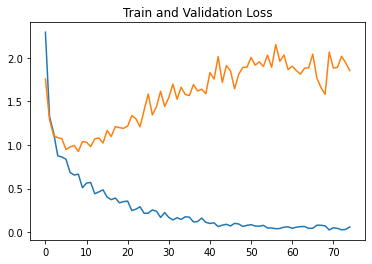

In [64]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Train and Validation Loss")


Text(0.5, 1.0, 'Validation Accuracy')

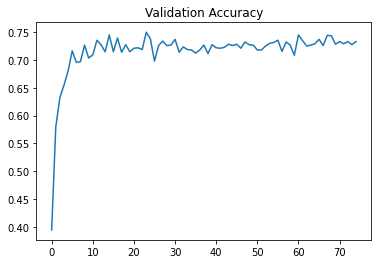

In [65]:
plt.plot(val_acc)
plt.title("Validation Accuracy")